In [1]:
import clip
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from PIL import Image
import os
from tqdm import tqdm
plt.style.use('seaborn-v0_8')

/Users/harrywang/sandbox/clip-tasks/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# select device: mps for Apple M1, cuda for GPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
#device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

mps


In [3]:
# local model and preprocessor
# see https://openai.com/blog/clip/ for info on different model
model, preprocess = clip.load("ViT-B/32", device=device)  # ViT-L/14@336px is the latest, ViT-B/32 is the first release, use ViT-L/14

In [4]:
# zero-shot classification for one image
labels = ['dawn', 'day', 'dusk', 'night']  # the target labels
text_prompts = ['A photo taken at ' + label for label in labels]
print(text_prompts)

['A photo taken at dawn', 'A photo taken at day', 'A photo taken at dusk', 'A photo taken at night']


(-0.5, 766.5, 511.5, -0.5)

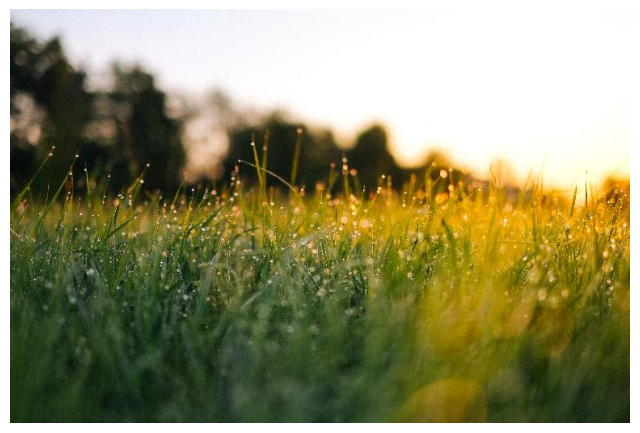

In [5]:
# try different images
#one_img = './1k-compressed/-bDYrrVAZnc.jpg'  # night
#one_img = './1k-compressed/-fjrjyS18BQ.jpg'  # dusk
im = './1k-compressed/-N_UwPdUs7E.jpg'  # dawn
#one_img = './1k-compressed/7kCNXfo35aU.jpg'  # day
plt.imshow(Image.open(im))
plt.axis('off')

In [6]:
image = preprocess(Image.open(im)).unsqueeze(0).to(device)  # preprocess image
text = clip.tokenize(text_prompts).to(device)  # tokenize the text

# encode the image and text - no used here
#image_features = model.encode_image(image)  # encode image
#text_features = model.encode_text(text)  # encode text

with torch.no_grad():  # inference with no_grad
    
    # logit scores are cosine similarities between the corresponding image and text features, times 100.
    logits_per_image, logits_per_text = model(image, text)
    
    #print(logits_per_image, logits_per_text)  # logits are the same
    
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # use softmax to get probabilities

print("Label probabilities:", probs)
choices = np.argmax(probs)  # use argmax to get the largest number as the prediction
print(f'This photo is classified as taken at {labels[choices]}.')

Label probabilities: [[0.488   0.1882  0.3152  0.00908]]
This photo is classified as taken at dawn.


In [7]:
# use 1k or 5k dataset - make sure you have `1k-compressed` or `5k-compressed` folders

data_size = '1k'

if data_size == '1k':
    photos = pd.read_csv('photos-1k.csv')
    img_folder = '1k-compressed'
    pred_csv = 'photos-1k-pred.csv'
else:
    photos = pd.read_csv('photos-5k.csv')
    img_folder = '5k-compressed'
    pred_csv = 'photos-5k-pred.csv'

In [8]:
# zero-shot classification for 1k/5k images
results = []

# zero-shot classification for one image
labels = ['dawn', 'day', 'dusk', 'night']  # the target labels
text_prompts = ['A photo taken at ' + label for label in labels]
print(text_prompts)

text = clip.tokenize(text_prompts).to(device)  # tokenize the text

BATCH_SIZE = 500
total_photos = len(photos)

for i in tqdm(range(0, total_photos, BATCH_SIZE)):
    
    # preprocess the images by batch
    images = [
        preprocess(  
            Image.open(f'./'+ img_folder + f'/{img_id}.jpg')
        ) for img_id in photos['photo_id'][i:i+BATCH_SIZE]
    ]

    image_input = torch.tensor(np.stack(images)).to(device)

    with torch.no_grad():
        
        # logit scores are cosine similarities between the corresponding image and text features, times 100.
        logits_per_image, logits_per_text = model(image_input, text)
        
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # softmax to get the probs from logits
        
        results.append(probs)

res = np.concatenate(results, axis=0)  # concat the result
choices = np.argmax(res, axis=1)  # choose the largest prob

get_labels = np.vectorize(lambda x:labels[x])  # vectorized lambda function to get labels
predictions = get_labels(choices)  # an array

#print(len(predictions))  # total 1000 predictions
#print(predictions[:10])  # see the first 10

# save the dataframe to csv
if not os.path.exists(pred_csv):  # skip if images had been processed
    # add the classification results to the dataframe
    photos['taken_time'] = predictions
    photos.to_csv(pred_csv, index=False)

['A photo taken at dawn', 'A photo taken at day', 'A photo taken at dusk', 'A photo taken at night']


100%|██████████| 2/2 [00:42<00:00, 21.24s/it]


<AxesSubplot: >

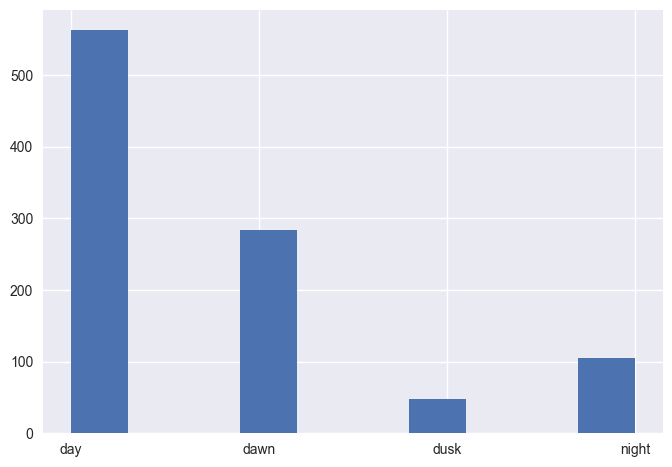

In [9]:
# random verify the result
# sample one for each cls: dusk, day, dawn, night

photos_pred = pd.read_csv(pred_csv)
photos_pred.taken_time.hist()

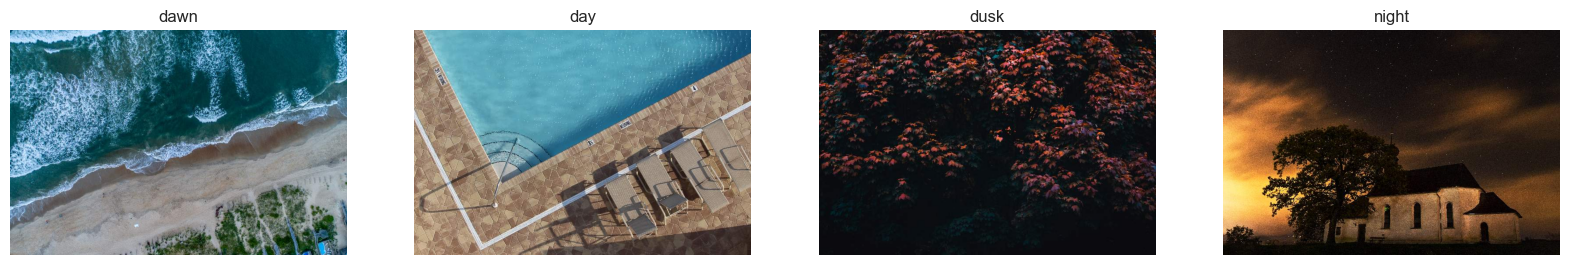

In [10]:
# random verify the result
# sample one for each cls: dusk, day, dawn, night

photos_pred = pd.read_csv(pred_csv)
samples = photos_pred.groupby('taken_time').sample(1)

ids = list(samples.photo_id)
labels = list(samples.taken_time)
total_photos = len(ids)
sample_photos = [f'./' + img_folder + '/' + idx + '.jpg' for idx in ids]

# display the result horizontally 
fig = figure(figsize=(20, 80))

for i in range(total_photos):
    ax = fig.add_subplot(1, total_photos, i+1)
    image = imread(sample_photos[i])
    imshow(image)
    ax.set_title(labels[i])
    axis('off')

In [11]:
# another example: zero-shot classification for 1k/5k images

results = []

# zero-shot classification for one image
labels = ['indoor', 'outdoor']  # the target labels
text_prompts = ['A photo taken ' + label for label in labels]
print(text_prompts)

text = clip.tokenize(text_prompts).to(device)  # tokenize the text

BATCH_SIZE = 500
total_photos = len(photos)

for i in tqdm(range(0, total_photos, BATCH_SIZE)):
    
    # preprocess the images by batch
    images = [
        preprocess(  
            Image.open(f'./' + img_folder+ f'/{img_id}.jpg')
        ) for img_id in photos['photo_id'][i:i+BATCH_SIZE]
    ]

    image_input = torch.tensor(np.stack(images)).to(device)

    with torch.no_grad():
        
        # logit scores are cosine similarities between the corresponding image and text features, times 100.
        logits_per_image, logits_per_text = model(image_input, text)
        
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # softmax to get the probs from logits
        
        results.append(probs)

res = np.concatenate(results, axis=0)  # concat the result
choices = np.argmax(res, axis=1)  # choose the largest prob

get_labels = np.vectorize(lambda x:labels[x])  # vectorized lambda function to get labels
predictions = get_labels(choices)  # an array

#print(len(predictions))  # total 1000 predictions
#print(predictions[:10])  # see the first 10

if not os.path.exists(pred_csv):  # skip if images had been processed 
    # add the classification results to the dataframe
    photos['taken_space'] = predictions
    photos.to_csv(pred_csv, index=False)

['A photo taken indoor', 'A photo taken outdoor']


100%|██████████| 2/2 [00:24<00:00, 12.34s/it]


<AxesSubplot: >

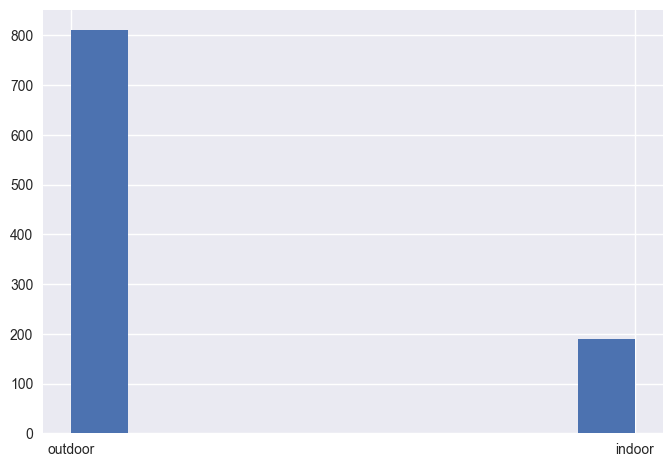

In [12]:
# random verify the indoor/outdoor classification

photos_pred = pd.read_csv(pred_csv)
photos_pred.taken_space.hist()

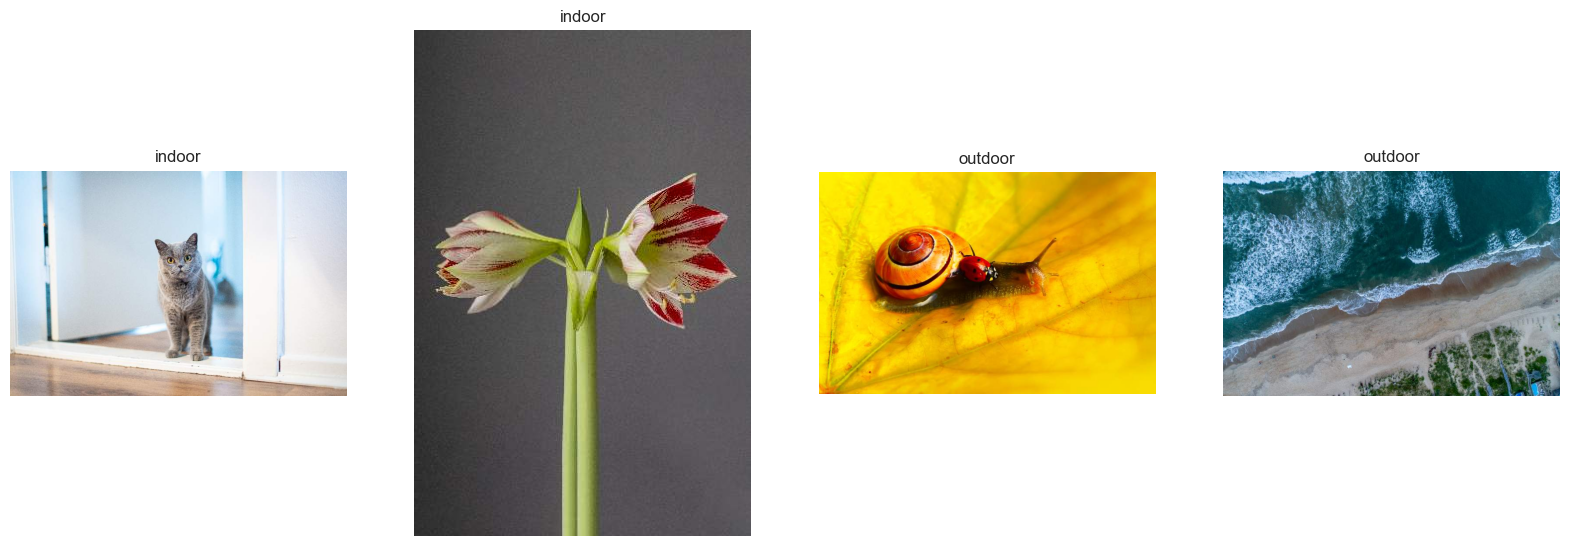

In [13]:
# random verify the result
# sample two for each cls: dusk, day, dawn, night

photos_pred = pd.read_csv(pred_csv)
samples = photos_pred.groupby('taken_space').sample(2)

ids = list(samples.photo_id)
labels = list(samples.taken_space)
total_photos = len(ids)
sample_photos = [f'./' + img_folder+ '/'+ idx + '.jpg' for idx in ids]

# display the result horizontally 
fig = figure(figsize=(20, 80))

for i in range(total_photos):
    ax = fig.add_subplot(1, total_photos, i+1)
    image = imread(sample_photos[i])
    imshow(image)
    ax.set_title(labels[i])
    axis('off')

Text(0.5, 1.0, 'taken_space')

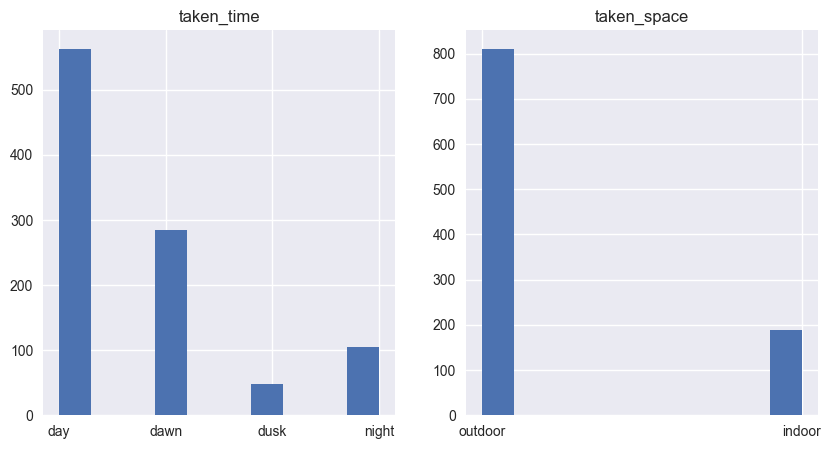

In [14]:
photos_pred = pd.read_csv(pred_csv)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

photos_pred.taken_time.hist(ax=ax[0])
photos_pred.taken_space.hist(ax=ax[1])
ax[0].set_title('taken_time')
ax[1].set_title('taken_space')